In [1]:
import pandas as pd
import string
import re
import nltk
import time
import pickle
import numpy as np


df = pickle.load( open( "files/df.pickle", "rb" ) )
df = df[df['Retweet']==False]
df.head()

,Tweet,Category,Retweet,Processed
0,i love lebron. http://bit.ly/PdHur,0,False,NN VBP NN _link_
1,"@ludajuice Lebron is a Beast, but I'm still ch...",0,False,_at_someone_ NN VBZ DT NN CC NN RB VBG CD DT N...
2,@wordwhizkid Lebron is a beast... nobody in th...,0,False,_at_someone_ NN VBZ DT NN NN IN DT NN VBZ RB JJ
3,Bill Simmons in conversation with Malcolm Glad...,0,False,NN NNS IN NN IN NN NN _link_
4,playing with Java and the Twitter API,0,False,VBG IN NN CC DT NN NN


In [2]:
# Russian Words

from sklearn.model_selection import train_test_split

X1, Xh1, y1, yh1 = train_test_split(df[df['Category']==1]['Processed'], df[df['Category']==1]['Category'], train_size=0.75)
X1.shape

(1730344,)

In [3]:
# Non-Russian Words

from sklearn.model_selection import train_test_split

X0, Xh0, y0, yh0 = train_test_split(df[df['Category']==0]['Processed'], df[df['Category']==0]['Category'], train_size=(X1.shape[0]/df[df['Category']==0].shape[0]))
X0.shape

(1730343,)

In [4]:
X = np.concatenate((X0,X1), axis=0)
y = np.concatenate((y0,y1), axis=0)
X.shape

(3460687,)

In [5]:
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer


# run a countvectorizer on the Tweets
start = time.time()
countVectorizer =  TfidfVectorizer(ngram_range=(2,5)
                                    , min_df = 500
                                    , max_df = .7
                                    , stop_words = None
                                   )
countVectorizer.fit(X)



countVectorizer.stop_words_ = None
pickle.dump( countVectorizer, open( "models/countVectorizer.pickle", "wb" ) )

end = time.time()
print('{} Number of tweets has {} cols and took {:.0f} s'.format(X.shape[0], countVectorizer.transform(X1).shape[1],end-start))

3460687 Number of tweets has 21615 cols and took 235 s


In [6]:
from sklearn.preprocessing import StandardScaler

start = time.time()
scaler = StandardScaler(with_mean=False)
X = countVectorizer.transform(X)
scaler.fit(X)
X = scaler.transform(X)
pickle.dump( scaler, open( "models/scaler.pickle", "wb" ) )
end = time.time()
print('{} Number of tweets has {} cols and took {:.0f} s'.format(X.shape[0], X.shape[1],end-start))

3460687 Number of tweets has 21615 cols and took 217 s


In [7]:
from sklearn.linear_model import LogisticRegression
start = time.time()
model = LogisticRegression(max_iter=10, penalty='l1', solver='saga')
X_train, X_test, y_train, y_test = train_test_split(X,y)
model.fit(X_train, y_train)
end = time.time()
print(model.score(X_train, y_train), model.score(X_test, y_test),"Took {} s".format(end-start))

C:\Users\darin\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.9004247711918444 0.8964252194939272 Took 2306.547507762909 s


In [8]:
model.score(scaler.transform(countVectorizer.transform(np.concatenate((Xh0, Xh1), axis=0))), np.concatenate((yh0,yh1),axis=0))

0.9095436693550049

In [9]:
pickle.dump( model, open( "models/regression.pickle", "wb" ) )

In [10]:
cv = pickle.load( open( "models/countVectorizer.pickle", "rb" ) )
scaler = pickle.load( open( "models/scaler.pickle", "rb" ) )
lr = pickle.load( open( "models/regression.pickle", "rb" ) )

In [11]:
y_score = lr.predict_proba(scaler.transform(cv.transform(np.concatenate((Xh0,Xh1), axis=0))))

y_test = np.concatenate((yh0,yh1), axis=0)

In [12]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


fpr, tpr, _ = roc_curve(y_test, y_score[:,1])
roc_auc = auc(fpr,tpr)

plt.figure()
plt.plot(fpr,tpr,color='b',label='ROC Curve {:.3f}'.format(roc_auc))
plt.plot([0,1],[0,1],color='k',linestyle='--')
plt.xlim([0,1])
plt.ylim(0,1.01)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Reciever-Operator Curve')
plt.legend()
plt.show()

<Figure size 640x480 with 1 Axes>

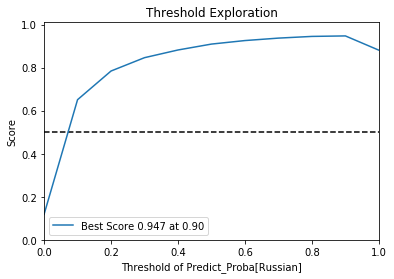

In [13]:
scores = []
threshold = [0.1*a for a in range(101)]
for th in threshold:
    scores.append(np.sum((y_score[:,1]>=th)==y_test)/y_test.shape[0])
plt.figure()
plt.plot(threshold,scores, label='Best Score {:.3f} at {:.2f}'.format(np.max(scores), threshold[scores.index(np.max(scores))]))
plt.hlines(0.5,0,1,color='k',linestyle='--')
plt.xlim([0,1])
plt.ylim(0,1.01)
plt.xlabel('Threshold of Predict_Proba[Russian]')
plt.ylabel('Score')
plt.title('Threshold Exploration')
plt.legend()
plt.show()